<a href="https://colab.research.google.com/github/athabrani/earthquake-prediction/blob/main/prediksi_gempa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_validate
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Reshape, Conv1D, MaxPooling1D, GRU
from tensorflow.keras.regularizers import l2
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.optimizers import Adam
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR, SVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score, mean_squared_error,accuracy_score, confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import warnings
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier
import time


warnings.filterwarnings('ignore')

#Earthquake Prediction

## Data Preparation

In [4]:
df = pd.read_csv("/content/katalog_gempa.csv")
print(f"Initial data shape: {df.shape}")

Initial data shape: (92887, 13)


In [5]:
print("Statistik Deskriptif Data Awal:")
print(df.describe(include='all'))

Statistik Deskriptif Data Awal:
               tgl            ot           lat           lon         depth  \
count        92887         92887  92887.000000  92887.000000  92887.000000   
unique        4412         90107           NaN           NaN           NaN   
top     2018/07/29  16:10:52.971           NaN           NaN           NaN   
freq           285             3           NaN           NaN           NaN   
mean           NaN           NaN     -3.404577    119.159707     49.009399   
std            NaN           NaN      4.354584     10.833202     76.761070   
min            NaN           NaN    -11.000000     94.020000      2.000000   
25%            NaN           NaN     -7.885000    113.170000     10.000000   
50%            NaN           NaN     -2.910000    121.160000     16.000000   
75%            NaN           NaN      0.140000    126.900000     54.000000   
max            NaN           NaN      6.000000    142.000000    750.000000   

                 mag           

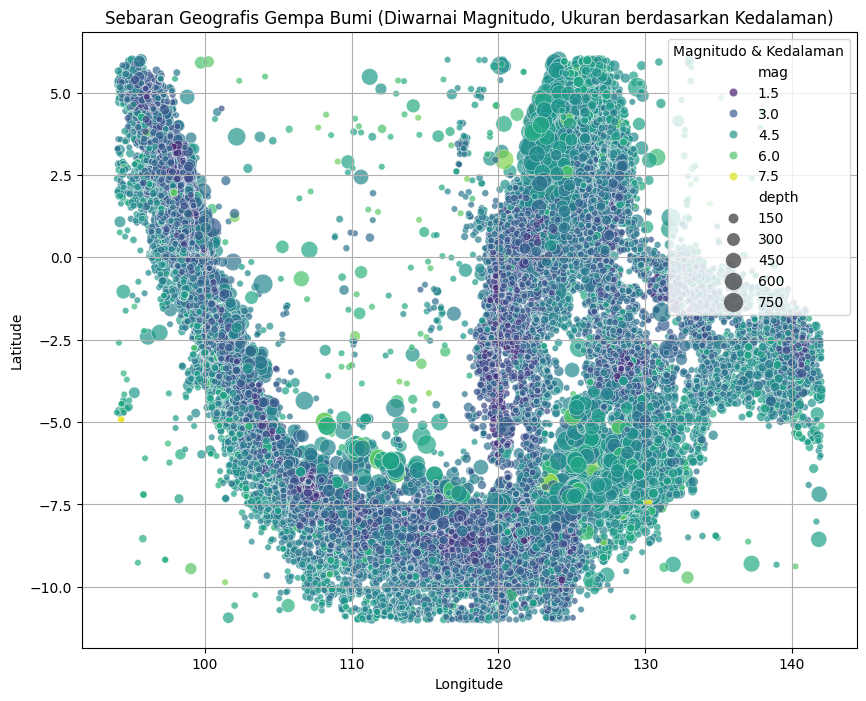

In [6]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x='lon', y='lat', data=df, hue='mag', palette='viridis', size='depth', sizes=(20, 200), alpha=0.7)
plt.title('Sebaran Geografis Gempa Bumi (Diwarnai Magnitudo, Ukuran berdasarkan Kedalaman)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Magnitudo & Kedalaman')
plt.grid(True)
plt.show()

In [8]:
df.isnull().sum()

,0
tgl,0
ot,0
lat,0
lon,0
depth,0
mag,0
remark,0
strike1,90152
dip1,90152
rake1,90152


In [9]:
df = df.drop(['ot','strike1', 'dip1', 'rake1', 'strike2', 'dip2', 'rake2'], axis=1)

In [10]:
print(df)

              tgl   lat     lon  depth  mag                      remark
0      2008/11/01 -9.18  119.06     10  4.9    Sumba Region - Indonesia
1      2008/11/01 -6.55  129.64     10  4.6                   Banda Sea
2      2008/11/01 -7.01  106.63    121  3.7            Java - Indonesia
3      2008/11/01 -3.30  127.85     10  3.2           Seram - Indonesia
4      2008/11/01 -6.41  129.54     70  4.3                   Banda Sea
...           ...   ...     ...    ...  ...                         ...
92882  2023/01/26  3.24  127.18     10  4.0  Talaud Islands - Indonesia
92883  2023/01/26  2.70  127.10     10  3.9        Northern Molucca Sea
92884  2023/01/26 -7.83  121.07     10  3.8                  Flores Sea
92885  2023/01/26  3.00  127.16     10  4.1        Northern Molucca Sea
92886  2023/01/26 -8.87  118.95     10  2.4  Sumbawa Region - Indonesia

[92887 rows x 6 columns]


In [11]:
df.isnull().sum()

,0
tgl,0
lat,0
lon,0
depth,0
mag,0
remark,0


In [12]:
df['tgl'] = pd.to_datetime(df['tgl'], format="%Y/%m/%d")

## Mapping Provinsi

In [13]:
provinsi_mapping = {
    # Sumatera
    "Aceh": "Aceh",
    "Northern Sumatra": "Sumatera Utara",
    "Southern Sumatra": ["Sumatera Selatan", "Lampung"],
    "Sumatra": "Sumatera Utara",
    "Padang": "Sumatera Barat",
    "Bengkulu": "Bengkulu",
    "Lampung": "Lampung",
    "Jambi": "Jambi",
    "Riau": "Riau",
    "Bangka": "Kepulauan Bangka Belitung",
    "Palembang": "Sumatera Selatan",
    "Medan": "Sumatera Utara",

    # Jawa
    "Sunda": ["Banten", "Lampung"],
    "Java": ["Jawa Barat", "Jawa Tengah", "Jawa Timur", "DKI Jakarta"],
    "Jakarta": "DKI Jakarta",
    "Yogyakarta": "DI Yogyakarta",
    "Surabaya": "Jawa Timur",
    "Bandung": "Jawa Barat",
    "Semarang": "Jawa Tengah",
    "Bogor": "Jawa Barat",
    "Cirebon": "Jawa Barat",
    "Tangerang": "Banten",

    # Bali-Nusa Tenggara
    "Bali": "Bali",
    "Denpasar": "Bali",
    "Lombok": "Nusa Tenggara Barat",
    "Mataram": "Nusa Tenggara Barat",
    "Sumbawa": "Nusa Tenggara Barat",
    "Flores": "Nusa Tenggara Timur",
    "Timor": "Nusa Tenggara Timur",
    "Sumba": "Nusa Tenggara Timur",
    "Kupang": "Nusa Tenggara Timur",
    "Ende": "Nusa Tenggara Timur",

    # Kalimantan
    "Kalimantan": "Kalimantan Tengah",
    "Pontianak": "Kalimantan Barat",
    "Palangkaraya": "Kalimantan Tengah",
    "Samarinda": "Kalimantan Timur",
    "Balikpapan": "Kalimantan Timur",
    "Tarakan": "Kalimantan Utara",
    "Banjarmasin": "Kalimantan Selatan",
    "Singkawang": "Kalimantan Barat",

    # Sulawesi
    "Sulawesi": "Sulawesi Tengah",
    "Palu": "Sulawesi Tengah",
    "Makassar": "Sulawesi Selatan",
    "Manado": "Sulawesi Utara",
    "Gorontalo": "Gorontalo",
    "Kendari": "Sulawesi Tenggara",
    "Minahassa": "Sulawesi Utara",
    "Mamuju": "Sulawesi Barat",
    "Parepare": "Sulawesi Selatan",

    # Maluku-Papua
    "Banda": ["Maluku", "Maluku Utara"],
    "Seram": "Maluku",
    "Ambon": "Maluku",
    "Ternate": "Maluku Utara",
    "Halmahera": "Maluku Utara",
    "Tidore": "Maluku Utara",
    "Papua": "Papua",
    "New Guinea": ["Papua", "Papua Barat"],
    "Jayapura": "Papua",
    "Manokwari": "Papua Barat",
    "Merauke": "Papua Selatan",
    "Mimika": "Papua Tengah",
    "Biak": "Papua",
    "Sorong": "Papua Barat",
    "Wamena": "Papua Pegunungan",

    # Kepulauan
    "Natuna": "Kepulauan Riau",
    "Anambas": "Kepulauan Riau",
    "Batam": "Kepulauan Riau",
    "Tanjung Pinang": "Kepulauan Riau",
    "Karimun": "Kepulauan Riau"
}

marine_mapping = {
    "Java Sea": ["Jawa Timur", "Kalimantan Barat", "Kepulauan Riau"],
    "Flores Sea": ["Sulawesi Selatan", "Nusa Tenggara Timur"],
    "Timor Sea": ["Nusa Tenggara Timur", "Maluku"],
    "Banda Sea": ["Maluku", "Maluku Utara", "Nusa Tenggara Timur"],
    "Bali Sea": ["Bali", "Nusa Tenggara Barat"],
    "Celebes Sea": ["Sulawesi Utara", "Kalimantan Utara"],
    "Arafura Sea": ["Papua", "Maluku"],
    "Sawu Sea": ["Nusa Tenggara Timur"],
    "Seram Sea": ["Maluku"],
    "Halmahera Sea": ["Maluku Utara"]
}

In [14]:
def map_to_province(remark):
    if not isinstance(remark, str):
        return ["Unknown"]

    remark_lower = remark.lower()

    for key, provinces in marine_mapping.items():
        if key.lower() in remark_lower:
            return provinces

    for key, province in provinsi_mapping.items():
        if key.lower() in remark_lower:
            if isinstance(province, list):
                return province
            return [province]

    if "west" in remark_lower and "sumatra" in remark_lower:
        return ["Sumatera Barat"]
    if "east" in remark_lower and "java" in remark_lower:
        return ["Jawa Timur"]
    if "central" in remark_lower and "sulawesi" in remark_lower:
        return ["Sulawesi Tengah"]

    return ["Unknown"]

In [15]:
df['provinsi_list'] = df['remark'].apply(map_to_province)
df = df.explode('provinsi_list')
df = df[df['provinsi_list'] != "Unknown"]
df = df.rename(columns={"provinsi_list": "provinsi"})

In [16]:
print(df.columns)

Index(['tgl', 'lat', 'lon', 'depth', 'mag', 'remark', 'provinsi'], dtype='object')


In [17]:
print("Jumlah provinsi yang tercover:", df['provinsi'].nunique())
print("Distribusi data per provinsi:")
print(df['provinsi'].value_counts())

Jumlah provinsi yang tercover: 21
Distribusi data per provinsi:
provinsi
Sulawesi Tengah        17330
Nusa Tenggara Timur    13105
Maluku                  9422
Jawa Timur              9395
Jawa Barat              9301
DKI Jakarta             9301
Jawa Tengah             9301
Maluku Utara            8888
Nusa Tenggara Barat     8407
Sumatera Utara          8034
Lampung                 6377
Sumatera Selatan        5314
Bali                    2950
Sulawesi Selatan        1879
Banten                  1063
Kalimantan Utara         525
Sulawesi Utara           525
Papua                    188
Kalimantan Barat          94
Kepulauan Riau            94
Papua Barat               61
Name: count, dtype: int64


## Feature Enginering

In [18]:
df = df.sort_values(['provinsi', 'tgl'])
df['target'] = 0

In [19]:
for provinsi in df['provinsi'].unique():
    prov_df = df[df['provinsi'] == provinsi]
    dates = prov_df['tgl'].values
    for i, current_date in enumerate(dates[:-30]):
        future_window = current_date + pd.Timedelta(days=30)
        future_events = (dates > current_date) & (dates <= future_window)
        if future_events.any():
            df.loc[(df['provinsi'] == provinsi) & (df['tgl'] == current_date), 'target'] = 1

In [20]:
df['day'] = df['tgl'].dt.day
df['month'] = df['tgl'].dt.month
df['day_of_year'] = df['tgl'].dt.dayofyear
features = ['day', 'month', 'day_of_year', 'depth', 'mag']

In [21]:
def create_sequences(group, window=30):
    scaler = MinMaxScaler()
    data = scaler.fit_transform(group[features])
    targets = group['target'].values[-len(data)+window:]

    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i+window])
        y.append(targets[i])
    return np.array(X), np.array(y), scaler

In [22]:
X_all, y_all, scalers = [], [], {}
for prov, group in df.groupby('provinsi'):
    if len(group) >= 60:
        X, y, scaler = create_sequences(group)
        X_all.append(X)
        y_all.append(y)
        scalers[prov] = scaler

X = np.concatenate(X_all)
y = np.concatenate(y_all)

In [23]:
print("\nClass distribution sebelum balancing:")
print(pd.Series(y).value_counts())


Class distribution sebelum balancing:
1    119900
0      1024
Name: count, dtype: int64


In [24]:
undersampler = RandomUnderSampler(random_state=42)
X_res, y_res = undersampler.fit_resample(X.reshape(X.shape[0], -1), y)
X_res = X_res.reshape(-1, X.shape[1], X.shape[2])

class_weights = compute_class_weight('balanced', classes=np.unique(y_res), y=y_res)
class_weights_dict = {0: class_weights[0], 1: class_weights[1]}

In [25]:
undersampled_counts = pd.Series(y_res).value_counts()
print("\n=== Class Distribution setelah Undersampling ===")
print(undersampled_counts)

print("\n=== Class Weights ===")
print(f"Class 0 (No Earthquake) weight: {class_weights_dict[0]:.2f}")
print(f"Class 1 (Earthquake) weight: {class_weights_dict[1]:.2f}")


=== Class Distribution setelah Undersampling ===
0    1024
1    1024
Name: count, dtype: int64

=== Class Weights ===
Class 0 (No Earthquake) weight: 1.00
Class 1 (Earthquake) weight: 1.00


## Model Comparation

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42, stratify=y_res)

In [29]:
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

In [ ]:
def evaluate_model(name, y_true, y_pred, train_time, pred_time):
    print(f"\n=== {name} ===")
    print(f"Train time: {train_time:.2f}s | Predict time: {pred_time:.2f}s")
    print(f"Accuracy : {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"Recall   : {recall_score(y_true, y_pred):.4f}")
    print(f"F1 Score : {f1_score(y_true, y_pred):.4f}")

# === Model yang menggunakan reshape ===
start_train = time.time()

# Random Forest
rf = make_pipeline(RandomForestClassifier(n_estimators=100, random_state=42))
rf.fit(X_train.reshape(X_train.shape[0], -1), y_train)

# XGBoost
xgb = make_pipeline(XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss'))
xgb.fit(X_train.reshape(X_train.shape[0], -1), y_train)

train_time_rf_xgb = time.time() - start_train

# Prediksi untuk RF dan XGB
start_pred = time.time()
rf_preds = rf.predict(X_test.reshape(X_test.shape[0], -1))
pred_time_rf = time.time() - start_pred

start_pred = time.time()
xgb_preds = xgb.predict(X_test.reshape(X_test.shape[0], -1))
pred_time_xgb = time.time() - start_pred

evaluate_model("Random Forest", y_test, rf_preds, train_time_rf_xgb, pred_time_rf)
evaluate_model("XGBoost", y_test, xgb_preds, train_time_rf_xgb, pred_time_xgb)

# === Model Sequential (LSTM dan GRU) ===
def build_and_train_model(model_type):
    model = Sequential([
        model_type(64, input_shape=(X_train.shape[1], X_train.shape[2])),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

    start_train = time.time()
    model.fit(X_train, y_train, epochs=10, batch_size=32,
              class_weight=class_weights_dict, validation_split=0.2, verbose=0)
    train_time = time.time() - start_train

    start_pred = time.time()
    preds = (model.predict(X_test) > 0.5).astype(int)
    pred_time = time.time() - start_pred

    return model, train_time, pred_time, preds

# LSTM
lstm_model, lstm_train_time, lstm_pred_time, lstm_preds = build_and_train_model(LSTM)
evaluate_model("LSTM", y_test, lstm_preds, lstm_train_time, lstm_pred_time)

# GRU
gru_model, gru_train_time, gru_pred_time, gru_preds = build_and_train_model(GRU)
evaluate_model("GRU", y_test, gru_preds, gru_train_time, gru_pred_time)


=== Random Forest ===
Train time: 2.47s | Predict time: 0.02s
Accuracy : 0.9415
Precision: 0.9502
Recall   : 0.9317
F1 Score : 0.9409

=== XGBoost ===
Train time: 2.47s | Predict time: 0.01s
Accuracy : 0.9415
Precision: 0.9415
Recall   : 0.9415
F1 Score : 0.9415
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step

=== LSTM ===
Train time: 14.35s | Predict time: 0.74s
Accuracy : 0.7585
Precision: 0.7548
Recall   : 0.7659
F1 Score : 0.7603
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step

=== GRU ===
Train time: 14.21s | Predict time: 1.37s
Accuracy : 0.6683
Precision: 0.8224
Recall   : 0.4293
F1 Score : 0.5641


## Building model

#LSTM

In [ ]:
model = Sequential([
    LSTM(128, input_shape=(X.shape[1], X.shape[2]), return_sequences=True,kernel_regularizer=l2(0.01), recurrent_dropout=0.2),
    Dropout(0.3),
    LSTM(64, kernel_regularizer=l2(0.01)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
      loss='binary_crossentropy',
      metrics=['accuracy', Precision(name='precision'),Recall(name='recall'), AUC(name='auc')]
)

In [ ]:
print(model.summary())

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 30, 128)        │        68,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 120,129 (469.25 KB)

 Trainable params: 120,129 (469.25 KB)

 Non-trainable params: 0 (0.00 B)

None


## Training Model

In [ ]:
callbacks = [
    EarlyStopping(monitor='val_auc', patience=5, mode='max', restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
    ]

In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=callbacks,
    class_weight=class_weights_dict,
    verbose=1
)

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 403ms/step - accuracy: 0.5798 - auc: 0.6027 - loss: 2.3557 - precision: 0.5630 - recall: 0.7485 - val_accuracy: 0.6268 - val_auc: 0.7085 - val_loss: 1.9540 - val_precision: 0.6757 - val_recall: 0.4878 - learning_rate: 0.0010
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 201ms/step - accuracy: 0.6471 - auc: 0.7179 - loss: 1.8423 - precision: 0.6794 - recall: 0.5579 - val_accuracy: 0.6902 - val_auc: 0.7431 - val_loss: 1.5428 - val_precision: 0.6931 - val_recall: 0.6829 - learning_rate: 0.0010
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 198ms/step - accuracy: 0.7068 - auc: 0.7636 - loss: 1.4497 - precision: 0.6954 - recall: 0.7228 - val_accuracy: 0.6902 - val_auc: 0.7542 - val_loss: 1.2610 - val_precision: 0.7241 - val_recall: 0.6146 - learning_rate: 0.0010
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 219ms/step - accuracy: 0.7118 - auc: 0.7824 - loss: 1.1779 - precision: 0.6967 - recall: 0.7139 - val_accuracy: 0.6561 - val_auc: 0.7638 - val_loss: 1.0734 - va

In [ ]:
results = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {results[0]:.4f}")
print(f"Test Accuracy: {results[1]:.4f}")
print(f"Test Precision: {results[2]:.4f}")
print(f"Test Recall: {results[3]:.4f}")

Test Loss: 0.4509
Test Accuracy: 0.7610
Test Precision: 0.7956
Test Recall: 0.7024


## Data Prediction

In [ ]:
prediksi_provinsi = []

for prov, group in df.groupby('provinsi'):
    group = group.sort_values('tgl').reset_index(drop=True)
    if len(group) >= 30:
        recent_data = group[-30:][features]

        scaler = MinMaxScaler()
        recent_scaled = scaler.fit_transform(recent_data)

        input_sequence = np.expand_dims(recent_scaled, axis=0)

        pred = model.predict(input_sequence)[0][0]
        klasifikasi = int(pred >= 0.5)

        prediksi_provinsi.append({
            'Provinsi': prov,
            'Probabilitas': pred,
            'Prediksi Gempa': klasifikasi
        })

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


In [ ]:
df_prediksi = pd.DataFrame(prediksi_provinsi).sort_values(by='Probabilitas', ascending=False)
print("\n=== Prediksi Gempa dalam 30 Hari ke Depan ===")
print(df_prediksi)


=== Prediksi Gempa dalam 30 Hari ke Depan ===
               Provinsi  Probabilitas  Prediksi Gempa
2           DKI Jakarta      0.522793               1
4           Jawa Tengah      0.522793               1
3            Jawa Barat      0.522793               1
5            Jawa Timur      0.522313               1
20       Sumatera Utara      0.503920               1
19     Sumatera Selatan      0.489573               0
11         Maluku Utara      0.483110               0
9               Lampung      0.468506               0
17      Sulawesi Tengah      0.460313               0
10               Maluku      0.436818               0
15          Papua Barat      0.430560               0
13  Nusa Tenggara Timur      0.427359               0
1                Banten      0.405903               0
16     Sulawesi Selatan      0.385064               0
12  Nusa Tenggara Barat      0.340557               0
14                Papua      0.164461               0
0                  Bali      0.1435

In [ ]:
print(model.summary())

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 30, 128)        │        68,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 360,389 (1.37 MB)

 Trainable params: 120,129 (469.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 240,260 (938.52 KB)

None


In [ ]:
# ==== SEL BARU 1: Simpan Model LSTM yang Telah Dilatih ====
# Pastikan variabel 'model' saat ini adalah model LSTM yang telah dilatih
# (setelah model.fit() dan model.evaluate())
try:
    model.save('actual_trained_lstm_model.h5')
    print("Model LSTM berhasil disimpan sebagai actual_trained_lstm_model.h5")
except Exception as e:
    print(f"Gagal menyimpan model LSTM: {e}")
    print("Pastikan variabel 'model' adalah model LSTM yang sudah dilatih.")

# ==== SEL BARU 2: Simpan Kamus Scalers ====
import joblib
try:
    joblib.dump(scalers, 'scalers_lstm.pkl')
    print("Kamus scalers berhasil disimpan sebagai scalers_lstm.pkl")
except Exception as e:
    print(f"Gagal menyimpan scalers: {e}")
    print("Pastikan variabel 'scalers' berisi dictionary MinMaxScaler per provinsi.")

# ==== SEL BARU 3: Simpan DataFrame yang Relevan untuk Flask ====
# Kita akan menyimpan df yang sudah memiliki kolom 'provinsi' dan fitur-fitur yang dibutuhkan
# Anda mungkin ingin melakukan pembersihan lebih lanjut atau menyimpan hanya kolom yang diperlukan
try:
    # Fitur yang dibutuhkan LSTM: 'day', 'month', 'day_of_year', 'depth', 'mag'
    # Kolom identifikasi: 'tgl', 'provinsi'
    df_for_flask = df[['tgl', 'provinsi', 'day', 'month', 'day_of_year', 'depth', 'mag']].copy()
    df_for_flask.to_csv('katalog_gempa_processed_for_flask.csv', index=False)
    print("DataFrame yang telah diproses disimpan sebagai katalog_gempa_processed_for_flask.csv")
except Exception as e:
    print(f"Gagal menyimpan DataFrame: {e}")

Model LSTM berhasil disimpan sebagai actual_trained_lstm_model.h5
Kamus scalers berhasil disimpan sebagai scalers_lstm.pkl
DataFrame yang telah diproses disimpan sebagai katalog_gempa_processed_for_flask.csv


In [ ]:
import requests
import base64
import tensorflow as tf

# Simpan model yang telah dilatih ke file .h5
model = tf.keras.models.Sequential([
    # Definisikan model Keras Anda di sini
    tf.keras.layers.Dense(32, activation='relu', input_shape=(3,)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.save('model_lstm.h5')

# Ganti dengan informasi repo GitHub Anda
username = 'athabrani'
repo = 'earthquake-prediction'
branch = 'main'
token = 'xxxxxxx'  # Ganti dengan Personal Access Token Anda

# Nama file lokal yang ingin dikirim
file_path = 'model_lstm.h5'
file_name = 'model_lstm.h5'
target_path_in_repo = f'models/{file_name}'  # Path di GitHub

# Baca file model dan konversi ke base64
with open(file_path, "rb") as f:
    content = base64.b64encode(f.read()).decode("utf-8")

# Kirim file ke GitHub via API
api_url = f'https://api.github.com/repos/{username}/{repo}/contents/{target_path_in_repo}'

headers = {
    "Authorization": f"token {token}",
    "Accept": "application/vnd.github.v3+json"
}

data = {
    "message": "Upload model .h5 from local machine",
    "branch": branch,
    "content": content
}

response = requests.put(api_url, headers=headers, json=data)

if response.status_code == 201:
    print("✅ Berhasil upload ke GitHub!")
    print("URL:", response.json()['content']['html_url'])
elif response.status_code == 422:
    print("⚠️ File sudah ada, atau konflik. Ganti nama atau hapus dulu di GitHub.")
else:
    print("❌ Gagal upload:", response.text)


✅ Berhasil upload ke GitHub!
URL: https://github.com/athabrani/earthquake-prediction/blob/main/models/model_lstm.h5


## Visualize

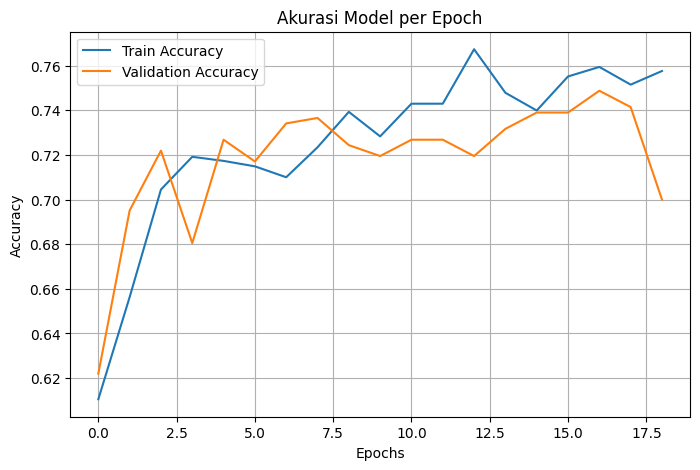

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Akurasi Model per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

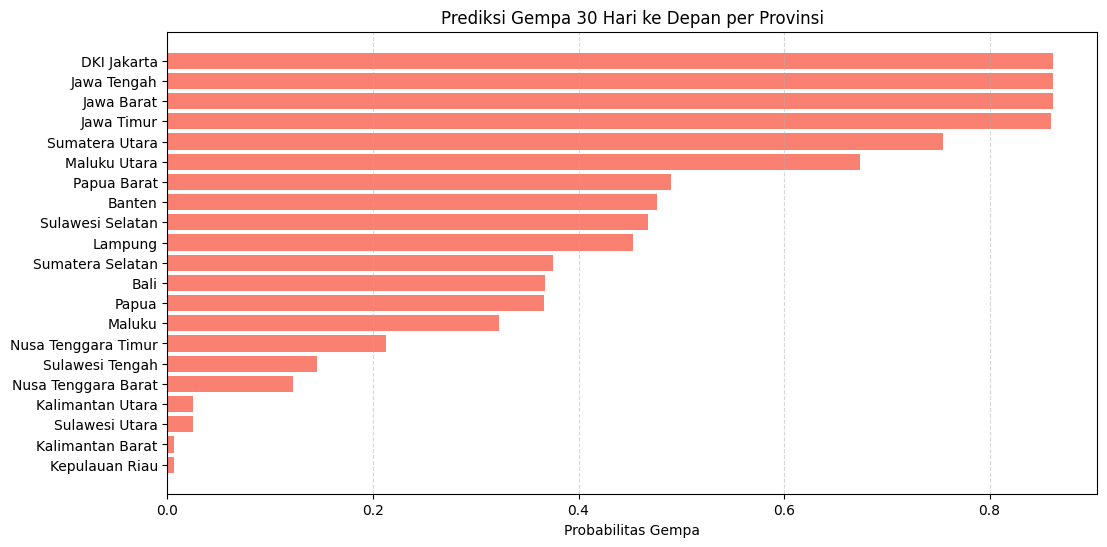

In [ ]:
plt.figure(figsize=(12,6))
plt.barh(df_prediksi['Provinsi'], df_prediksi['Probabilitas_Gempa_30_Hari'], color='salmon')
plt.xlabel('Probabilitas Gempa')
plt.title('Prediksi Gempa 30 Hari ke Depan per Provinsi')
plt.gca().invert_yaxis()
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.show()

#RandomF


### Melatih RandomForestClassifier untuk Prediksi Kejadian Gempa (Biner) ###
X_train memiliki dimensi 3D ((1638, 30, 5)), akan di-flatten.
X_train di-flatten menjadi (1638, 150), X_test di-flatten menjadi (410, 150)
Model RandomForestClassifier berhasil dilatih.

--- Evaluasi RandomForestClassifier pada Data Test ---
Accuracy: 0.9415
Precision: 0.9502
Recall: 0.9317
F1-score: 0.9409

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       205
           1       0.95      0.93      0.94       205

    accuracy                           0.94       410
   macro avg       0.94      0.94      0.94       410
weighted avg       0.94      0.94      0.94       410



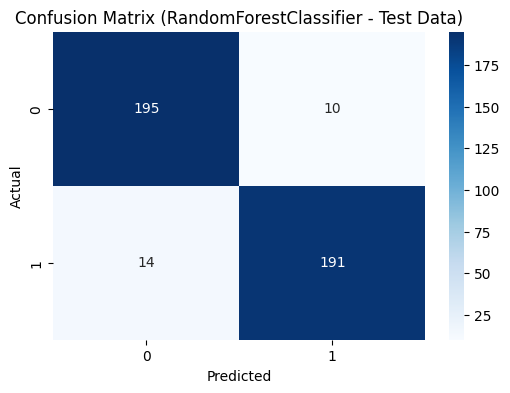


=== Prediksi Kejadian Gempa (RF Classifier) dalam 30 Hari ke Depan ===

=== Prediksi Gempa (Random Forest) dalam 30 Hari ke Depan ===
               Provinsi Probabilitas  Prediksi Gempa
0                  Bali       48.00%               0
16     Sulawesi Selatan       32.00%               0
1                Banten       31.00%               0
13  Nusa Tenggara Timur       30.00%               0
14                Papua       25.00%               0
17      Sulawesi Tengah       24.00%               0
6      Kalimantan Barat       22.00%               0
8        Kepulauan Riau       22.00%               0
15          Papua Barat       19.00%               0
18       Sulawesi Utara       17.00%               0
7      Kalimantan Utara       17.00%               0
11         Maluku Utara       13.00%               0
12  Nusa Tenggara Barat       10.00%               0
10               Maluku        9.00%               0
5            Jawa Timur        8.00%               0
2           DKI J

In [33]:
WINDOW_SIZE = 30 # Sesuaikan jika window size Anda berbeda
rf_classifier = None # Inisialisasi
scaler_rf_global = None # Inisialisasi scaler global jika diperlukan

# --- Blok Pelatihan RandomForestClassifier ---
# Asumsi X_train dan y_train adalah data yang sudah diproses untuk klasifikasi
# (misalnya, dari X_res dan y_res yang telah di-split dan X_res di-flatten)

if 'X_train' in locals() and 'y_train' in locals() and len(np.unique(y_train)) <= 2:
    print("### Melatih RandomForestClassifier untuk Prediksi Kejadian Gempa (Biner) ###")

    X_train_for_rf = X_train.copy()
    X_test_for_rf = X_test.copy()

    # Jika X_train (dari X_res) masih 3D (samples, timesteps, features_per_timestep)
    if X_train_for_rf.ndim == 3:
        print(f"X_train memiliki dimensi 3D ({X_train_for_rf.shape}), akan di-flatten.")
        nsamples_train, nx_train, ny_train = X_train_for_rf.shape
        X_train_for_rf = X_train_for_rf.reshape((nsamples_train, nx_train * ny_train))

        nsamples_test, nx_test, ny_test = X_test_for_rf.shape
        X_test_for_rf = X_test_for_rf.reshape((nsamples_test, nx_test * ny_test))
        print(f"X_train di-flatten menjadi {X_train_for_rf.shape}, X_test di-flatten menjadi {X_test_for_rf.shape}")
    elif X_train_for_rf.ndim != 2:
        raise ValueError("X_train untuk RandomForestClassifier harus 2D (samples, features) atau 3D (samples, timesteps, features_per_timestep) untuk di-flatten.")

    # Penskalaan Data Training untuk RF (jika belum diskalakan dengan cara yang diinginkan untuk RF)
    # Jika X_train (berasal dari X_res) sudah diskalakan per provinsi oleh LSTM,
    # dan Anda ingin menggunakan data yang sudah diskalakan tersebut, maka tidak perlu scaling ulang global di sini.
    # Namun, jika Anda ingin pendekatan scaling yang berbeda khusus untuk RF, lakukan di sini.
    # Contoh: menggunakan scaler global baru jika X_train_for_rf adalah fitur yang belum diskalakan
    # scaler_rf_global = MinMaxScaler()
    # X_train_for_rf = scaler_rf_global.fit_transform(X_train_for_rf)
    # X_test_for_rf = scaler_rf_global.transform(X_test_for_rf)
    # print("Data training dan testing untuk RF telah di-scale dengan scaler_rf_global.")

    rf_classifier = RandomForestClassifier(n_estimators=100,
                                         random_state=42,
                                         class_weight='balanced',
                                         n_jobs=-1)
    rf_classifier.fit(X_train_for_rf, y_train)
    print("Model RandomForestClassifier berhasil dilatih.")

    # --- Kode Evaluasi ---
    print("\n--- Evaluasi RandomForestClassifier pada Data Test ---")
    y_pred_rf_test = rf_classifier.predict(X_test_for_rf)
    y_prob_rf_test = rf_classifier.predict_proba(X_test_for_rf)[:, 1]

    print(f"Accuracy: {accuracy_score(y_test, y_pred_rf_test):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred_rf_test, zero_division=0):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred_rf_test, zero_division=0):.4f}")
    print(f"F1-score: {f1_score(y_test, y_pred_rf_test, zero_division=0):.4f}")


    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_rf_test, zero_division=0))

    cm_rf = confusion_matrix(y_test, y_pred_rf_test)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix (RandomForestClassifier - Test Data)')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    if hasattr(rf_classifier, 'feature_importances_'):
        # Membuat nama fitur dummy jika X_train_for_rf bukan DataFrame
        if isinstance(X_train_for_rf, pd.DataFrame):
            feature_names_rf = X_train_for_rf.columns
        else:
            feature_names_rf = [f'flat_feat_{i}' for i in range(X_train_for_rf.shape[1])]

        importances_rf = rf_classifier.feature_importances_
        forest_importances_rf = pd.Series(importances_rf, index=feature_names_rf).sort_values(ascending=False)


else:
    print("Data training (X_train, y_train) tidak ditemukan atau y_train bukan biner. RandomForestClassifier tidak dilatih.")

# --- Bagian Prediksi dengan RandomForestClassifier untuk Provinsi ---
if rf_classifier and hasattr(rf_classifier, 'n_features_in_'):
    print("\n=== Prediksi Kejadian Gempa (RF Classifier) dalam 30 Hari ke Depan ===")
    prediksi_provinsi_rf_clf_list = []

    if 'features' not in locals() or not isinstance(features, list):
        raise NameError("Variabel 'features' (list nama kolom) belum didefinisikan dengan benar.")
    if 'df' not in locals() or not isinstance(df, pd.DataFrame):
        raise NameError("DataFrame 'df' belum didefinisikan.")

    # Pilihan Penskalaan untuk Prediksi:
    # Opsi 1: Menggunakan dictionary 'scalers' per provinsi (dari LSTM)
    use_provincial_scalers = 'scalers' in locals() and isinstance(scalers, dict)
    if not use_provincial_scalers and scaler_rf_global is None:
        print("Peringatan: Tidak ada 'scalers' per provinsi maupun 'scaler_rf_global' yang sudah di-fit.")
        print("Penskalaan pada prediksi mungkin tidak konsisten. Disarankan melatih scaler global.")

    for prov, group in df.groupby('provinsi'):
        group_sorted = group.sort_values('tgl').reset_index(drop=True)
        if len(group_sorted) >= WINDOW_SIZE:
            recent_data_sequence_unscaled = group_sorted[-WINDOW_SIZE:][features]

            # Penskalaan
            if use_provincial_scalers and prov in scalers:
                scaler_to_use = scalers[prov]
                try:
                    recent_scaled_sequence = scaler_to_use.transform(recent_data_sequence_unscaled)
                except Exception as e:
                    print(f"Error transform data {prov} dengan scaler provinsi: {e}. Fallback.")
                    temp_scaler = MinMaxScaler().fit(recent_data_sequence_unscaled) # Kurang ideal
                    recent_scaled_sequence = temp_scaler.transform(recent_data_sequence_unscaled)
            elif scaler_rf_global: # Jika ada scaler global yang dilatih untuk RF
                recent_scaled_sequence = scaler_rf_global.transform(recent_data_sequence_unscaled)
            else: # Fallback paling akhir (kurang ideal)
                print(f"Peringatan: Tidak ada scaler cocok untuk {prov}. Menggunakan fit_transform sementara.")
                temp_scaler = MinMaxScaler()
                recent_scaled_sequence = temp_scaler.fit_transform(recent_data_sequence_unscaled)

            input_flattened_rf = recent_scaled_sequence.flatten().reshape(1, -1)

            if input_flattened_rf.shape[1] == rf_classifier.n_features_in_:
                pred_prob_rf = rf_classifier.predict_proba(input_flattened_rf)[0][1]
                klasifikasi_rf = int(pred_prob_rf >= 0.5)

                prediksi_provinsi_rf_clf_list.append({
                    'Provinsi': prov,
                    'Probabilitas_raw': pred_prob_rf,
                    'Probabilitas': f"{pred_prob_rf*100:.2f}%",
                    'Prediksi Gempa': klasifikasi_rf
                })
            else:
                print(f"Skipping {prov} for RF Classifier: feature mismatch (expected {rf_classifier.n_features_in_}, got {input_flattened_rf.shape[1]})")
        else:
            print(f"Skipping {prov} for RF Classifier: data tidak cukup (< {WINDOW_SIZE} observasi).")

    if prediksi_provinsi_rf_clf_list:
        df_prediksi_rf = pd.DataFrame(prediksi_provinsi_rf_clf_list).sort_values(by='Probabilitas_raw', ascending=False)
        print("\n=== Prediksi Gempa (Random Forest) dalam 30 Hari ke Depan ===")
        print(df_prediksi_rf[['Provinsi', 'Probabilitas', 'Prediksi Gempa']])
    else:
        print("Tidak ada prediksi klasifikasi RF yang dihasilkan.")
else:
    print("\nModel RandomForestClassifier belum dilatih atau tidak siap untuk prediksi.")


#Model comparison for mag


In [ ]:
scalers = {
    'MinMaxScaler': MinMaxScaler(),
    'StandardScaler': StandardScaler()
}

# Models for comparison - USE REGRESSORS
models = {
    'Linear Regression': LinearRegression(),
    'SVM': SVR(), # Changed from SVC
    'Decision Tree': DecisionTreeRegressor(), # Changed from DecisionTreeClassifier
    'Random Forest': RandomForestRegressor(), # Changed from RandomForestClassifier
    'XGBoost': xgb.XGBRegressor(use_label_encoder=False, eval_metric='rmse') # Changed to XGBRegressor and eval_metric
}

# Results dictionary to store results
results = {}

# Train and evaluate each model using different scalers
for scaler_name, scaler in scalers.items():
    # Scale the data
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model_results = {}

    # Train and evaluate each model
    for model_name, model in models.items():
        print(f"Training {model_name} with {scaler_name}...")
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)

        # Use a regression metric (MSE) for ALL models
        mse = mean_squared_error(y_test, y_pred)
        model_results[model_name] = mse

    results[scaler_name] = model_results

# Display results
print("\nPerformance (Mean Squared Error) for each model with different scalers:")
for scaler_name, model_results in results.items():
    print(f"\nScaler: {scaler_name}")
    for model_name, performance in model_results.items():
        print(f"{model_name}: {performance:.4f}")

Training Linear Regression with MinMaxScaler...
Training SVM with MinMaxScaler...
Training Decision Tree with MinMaxScaler...
Training Random Forest with MinMaxScaler...
Training XGBoost with MinMaxScaler...
Training Linear Regression with StandardScaler...
Training SVM with StandardScaler...
Training Decision Tree with StandardScaler...
Training Random Forest with StandardScaler...
Training XGBoost with StandardScaler...

Performance (Mean Squared Error) for each model with different scalers:

Scaler: MinMaxScaler
Linear Regression: 0.6241
SVM: 0.4700
Decision Tree: 0.3489
Random Forest: 0.2163
XGBoost: 0.3603

Scaler: StandardScaler
Linear Regression: 0.6241
SVM: 0.4626
Decision Tree: 0.3487
Random Forest: 0.2156
XGBoost: 0.3603


#Regresi Linear

In [ ]:
# Select relevant columns
X = df[['lat', 'lon', 'depth']]
y = df['mag']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
print(X_train.shape)  # Memeriksa dimensi X_train
print(X_test.shape)

(74309, 3)
(18578, 3)


In [ ]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

In [ ]:
scores= {"Model name": ["Linear regression", "SVM", "Random Forest"], "mse": [], "R^2": []}

# Predict on the testing set
y_pred = regressor.predict(X_test)

# Compute R^2 and MSE
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

scores['mse'].append(mse)
scores['R^2'].append(r2)

print("R^2: {:.2f}, MSE: {:.2f}".format(r2, mse))

R^2: 0.07, MSE: 0.64


##newdata dari provinsi yang telah di berikan

In [ ]:
provinsi_data = [
    {"provinsi": "DKI Jakarta", "lat": -6.2088, "lon": 106.8456, "depth": 10, "probabilitas": 0.861863, "prediksi": 1},
    {"provinsi": "Jawa Tengah", "lat": -7.1500, "lon": 110.3500, "depth": 15, "probabilitas": 0.861863, "prediksi": 1},
    {"provinsi": "Jawa Barat", "lat": -6.9000, "lon": 107.6000, "depth": 20, "probabilitas": 0.861863, "prediksi": 1},
    {"provinsi": "Jawa Timur", "lat": -7.2500, "lon": 112.7500, "depth": 30, "probabilitas": 0.859839, "prediksi": 1},
    {"provinsi": "Sumatra Utara", "lat": 3.5952, "lon": 98.6722, "depth": 150, "probabilitas": 0.754349, "prediksi": 1},
    {"provinsi": "Maluku Utara", "lat": -3.3147, "lon": 127.2688, "depth": 200, "probabilitas": 0.673919, "prediksi": 1},
    {"provinsi": "Papua Barat", "lat": -2.0200, "lon": 134.0175, "depth": 300, "probabilitas": 0.490018, "prediksi": 0},
    {"provinsi": "Banten", "lat": -6.1000, "lon": 106.0000, "depth": 10, "probabilitas": 0.476402, "prediksi": 0},
    {"provinsi": "Sulawesi Selatan", "lat": -5.1478, "lon": 119.4323, "depth": 50, "probabilitas": 0.467954, "prediksi": 0},
    {"provinsi": "Lampung", "lat": -5.1850, "lon": 105.2561, "depth": 25, "probabilitas": 0.453368, "prediksi": 0},
    {"provinsi": "Sumatera Selatan", "lat": -3.2958, "lon": 104.7333, "depth": 60, "probabilitas": 0.374720, "prediksi": 0},
    {"provinsi": "Bali", "lat": -8.4095, "lon": 115.1889, "depth": 100, "probabilitas": 0.367623, "prediksi": 0},
    {"provinsi": "Papua", "lat": -4.7217, "lon": 140.7719, "depth": 200, "probabilitas": 0.366819, "prediksi": 0},
    {"provinsi": "Maluku", "lat": -3.7123, "lon": 128.1889, "depth": 120, "probabilitas": 0.322242, "prediksi": 0},
    {"provinsi": "Nusa Tenggara Timur", "lat": -8.4095, "lon": 121.2555, "depth": 140, "probabilitas": 0.212398, "prediksi": 0},
    {"provinsi": "Sulawesi Tengah", "lat": -2.9033, "lon": 120.0733, "depth": 170, "probabilitas": 0.145832, "prediksi": 0},
    {"provinsi": "Nusa Tenggara Barat", "lat": -8.4500, "lon": 116.2500, "depth": 110, "probabilitas": 0.121918, "prediksi": 0},
    {"provinsi": "Kalimantan Utara", "lat": 3.5940, "lon": 116.0810, "depth": 130, "probabilitas": 0.024462, "prediksi": 0},
    {"provinsi": "Sulawesi Utara", "lat": 1.5000, "lon": 124.9333, "depth": 90, "probabilitas": 0.024462, "prediksi": 0},
    {"provinsi": "Kalimantan Barat", "lat": -0.2398, "lon": 109.3500, "depth": 200, "probabilitas": 0.006799, "prediksi": 0},
    {"provinsi": "Kepulauan Riau", "lat": 0.0000, "lon": 104.0000, "depth": 50, "probabilitas": 0.006799, "prediksi": 0},
]

# Perulangan untuk memprediksi magnitude berdasarkan koordinat dari setiap provinsi
for provinsi in provinsi_data:
    # Ambil latitude, longitude, dan depth untuk setiap provinsi
    lat = provinsi['lat']
    lon = provinsi['lon']
    depth = provinsi['depth']

    # Buat data baru untuk prediksi
    new_data = [[lat, lon, depth]]

    # Prediksi menggunakan model regressor
    new_pred = regressor.predict(new_data)

    # Tampilkan hasil prediksi untuk setiap provinsi
    print(f"Prediksi magnitude gempa untuk {provinsi['provinsi']}: {new_pred[0]:.2f}")

Prediksi magnitude gempa untuk DKI Jakarta: 3.36
Prediksi magnitude gempa untuk Jawa Tengah: 3.37
Prediksi magnitude gempa untuk Jawa Barat: 3.37
Prediksi magnitude gempa untuk Jawa Timur: 3.42
Prediksi magnitude gempa untuk Sumatra Utara: 3.87
Prediksi magnitude gempa untuk Maluku Utara: 4.02
Prediksi magnitude gempa untuk Papua Barat: 4.34
Prediksi magnitude gempa untuk Banten: 3.35
Prediksi magnitude gempa untuk Sulawesi Selatan: 3.56
Prediksi magnitude gempa untuk Lampung: 3.41
Prediksi magnitude gempa untuk Sumatera Selatan: 3.53
Prediksi magnitude gempa untuk Bali: 3.59
Prediksi magnitude gempa untuk Papua: 4.07
Prediksi magnitude gempa untuk Maluku: 3.82
Prediksi magnitude gempa untuk Nusa Tenggara Timur: 3.72
Prediksi magnitude gempa untuk Sulawesi Tengah: 3.91
Prediksi magnitude gempa untuk Nusa Tenggara Barat: 3.62
Prediksi magnitude gempa untuk Kalimantan Utara: 3.92
Prediksi magnitude gempa untuk Sulawesi Utara: 3.84
Prediksi magnitude gempa untuk Kalimantan Barat: 3.97
Pre

##

In [ ]:
# Predict on new data
new_data = [[-7.01, 106.63, 121 ], [-7.83, 121.07	, 10]] #jawa barat dan sulawesi selatan
new_pred = regressor.predict(new_data)
print("New predictions magnitude:", new_pred)

New predictions magnitude: [3.61447227 3.4110998 ]


In [ ]:
# Menyimpan model ke file .h5
model.save('model.h5')  # Pastikan Anda sudah melatih model terlebih dahulu

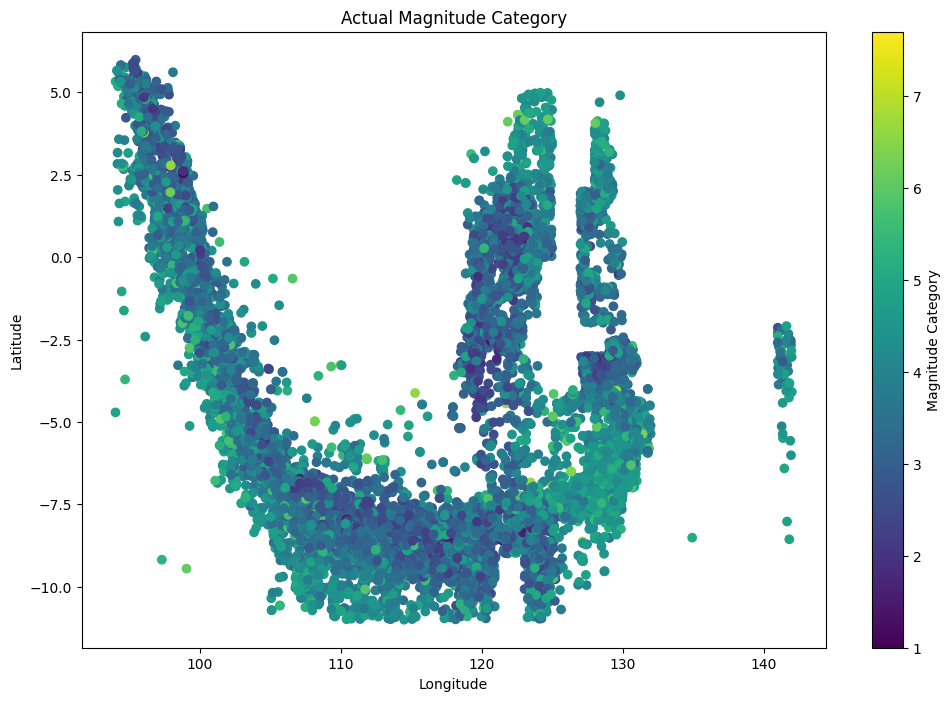

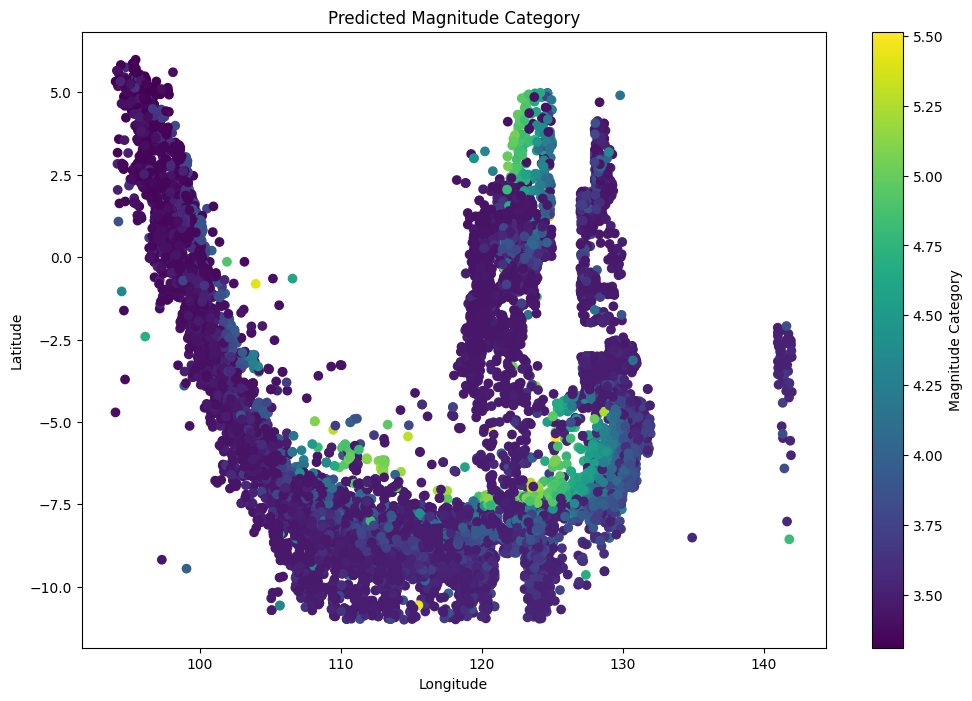

In [ ]:
# Create a scatter plot of actual vs predicted values
plt.figure(figsize=(12, 8))
scatter_actual = plt.scatter(X_test['lon'], X_test['lat'], c=y_test, cmap='viridis')
plt.title('Actual Magnitude Category')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(scatter_actual, label='Magnitude Category')  # Adding colorbar for actual values
plt.show()
print(" ")

plt.figure(figsize=(12, 8))
scatter_predicted = plt.scatter(X_test['lon'], X_test['lat'], c=y_pred, cmap='viridis')
plt.title('Predicted Magnitude Category')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(scatter_predicted, label='Magnitude Category')  # Adding colorbar for predicted values
plt.show()
print(" ")


##export to github


In [ ]:
import requests
import base64
import tensorflow as tf

# Simpan model yang telah dilatih ke file .h5
model = tf.keras.models.Sequential([
    # Definisikan model Keras Anda di sini
    tf.keras.layers.Dense(32, activation='relu', input_shape=(3,)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.save('model.h5')

# Ganti dengan informasi repo GitHub Anda
username = 'athabrani'
repo = 'earthquake-prediction'
branch = 'main'
token = 'xxxxxxxxx'  # Ganti dengan Personal Access Token Anda

# Nama file lokal yang ingin dikirim
file_path = 'model.h5'
file_name = 'model.h5'
target_path_in_repo = f'models/{file_name}'  # Path di GitHub

# Baca file model dan konversi ke base64
with open(file_path, "rb") as f:
    content = base64.b64encode(f.read()).decode("utf-8")

# Kirim file ke GitHub via API
api_url = f'https://api.github.com/repos/{username}/{repo}/contents/{target_path_in_repo}'

headers = {
    "Authorization": f"token {token}",
    "Accept": "application/vnd.github.v3+json"
}

data = {
    "message": "Upload model .h5 from local machine",
    "branch": branch,
    "content": content
}

response = requests.put(api_url, headers=headers, json=data)

if response.status_code == 201:
    print("✅ Berhasil upload ke GitHub!")
    print("URL:", response.json()['content']['html_url'])
elif response.status_code == 422:
    print("⚠️ File sudah ada, atau konflik. Ganti nama atau hapus dulu di GitHub.")
else:
    print("❌ Gagal upload:", response.text)


✅ Berhasil upload ke GitHub!
URL: https://github.com/athabrani/earthquake-prediction/blob/main/models/model.h5


#SVM

In [ ]:
subset_size = 500
X_train_subset = X_train[:subset_size]
y_train_subset = y_train[:subset_size]

# Create an SVM model
svm = SVR(kernel='rbf', C=1e3, gamma=0.1)

# Train the SVM model on the subset of data
svm.fit(X_train_subset, y_train_subset)

# Evaluate the model on the test set
score = svm.score(X_test, y_test)
print("Test score:", score)

Test score: -1.5389618144658637


In [ ]:
# Predict on the testing set
y_pred_svm = svm.predict(X_test)

# Compute R^2 and MSE
r2_svm = r2_score(y_test, y_pred_svm)
mse_svm = mean_squared_error(y_test, y_pred_svm)

scores['mse'].append(mse_svm)
scores['R^2'].append(r2_svm)

print("SVM R^2: {:.2f}, MSE: {:.2f}".format(r2_svm, mse_svm))

SVM R^2: -1.54, MSE: 1.76


In [ ]:
# Predict on new data
new_pred_svm = svm.predict(new_data)
print("New SVM predictions:", new_pred_svm)

New SVM predictions: [3.64004393 3.70697174]


#Random Forest

In [ ]:
# Initialize a random forest regressor with 100 trees
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the regressor to the training data
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [ ]:
# Predict the target variable on the test data
y_pred = rf.predict(X_test)

# Evaluate the performance of the model using mean squared error and R^2 score
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

scores['mse'].append(mse)
scores['R^2'].append(r2)

print('Mean Squared Error: ', mse)
print('R^2 Score: ', r2)

Mean Squared Error:  0.4061316338173855
R^2 Score:  0.41573324725720384


In [ ]:
for provinsi in provinsi_data:
    # Ambil latitude, longitude, dan depth untuk setiap provinsi
    lat = provinsi['lat']
    lon = provinsi['lon']
    depth = provinsi['depth']

    # Buat data baru untuk prediksi
    new_data = [[lat, lon, depth]]

    # Prediksi menggunakan model regressor
    new_pred = regressor.predict(new_data)

    # Tampilkan hasil prediksi untuk setiap provinsi
    print(f"Prediksi magnitude gempa untuk {provinsi['provinsi']}: {new_pred[0]:.2f}")

Prediksi magnitude gempa untuk DKI Jakarta: 3.36
Prediksi magnitude gempa untuk Jawa Tengah: 3.37
Prediksi magnitude gempa untuk Jawa Barat: 3.37
Prediksi magnitude gempa untuk Jawa Timur: 3.42
Prediksi magnitude gempa untuk Sumatra Utara: 3.87
Prediksi magnitude gempa untuk Maluku Utara: 4.02
Prediksi magnitude gempa untuk Papua Barat: 4.34
Prediksi magnitude gempa untuk Banten: 3.35
Prediksi magnitude gempa untuk Sulawesi Selatan: 3.56
Prediksi magnitude gempa untuk Lampung: 3.41
Prediksi magnitude gempa untuk Sumatera Selatan: 3.53
Prediksi magnitude gempa untuk Bali: 3.59
Prediksi magnitude gempa untuk Papua: 4.07
Prediksi magnitude gempa untuk Maluku: 3.82
Prediksi magnitude gempa untuk Nusa Tenggara Timur: 3.72
Prediksi magnitude gempa untuk Sulawesi Tengah: 3.91
Prediksi magnitude gempa untuk Nusa Tenggara Barat: 3.62
Prediksi magnitude gempa untuk Kalimantan Utara: 3.92
Prediksi magnitude gempa untuk Sulawesi Utara: 3.84
Prediksi magnitude gempa untuk Kalimantan Barat: 3.97
Pre

In [ ]:
new_pred_rf = rf.predict(new_data)
print("\nPrediksi baru:", new_pred_rf)


Prediksi baru: [3.783 3.431]


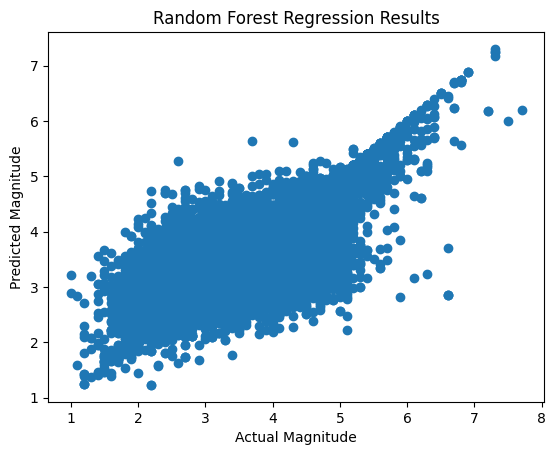

In [ ]:
# Plot the predicted and actual values
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Magnitude')
plt.ylabel('Predicted Magnitude')
plt.title('Random Forest Regression Results')
plt.show()

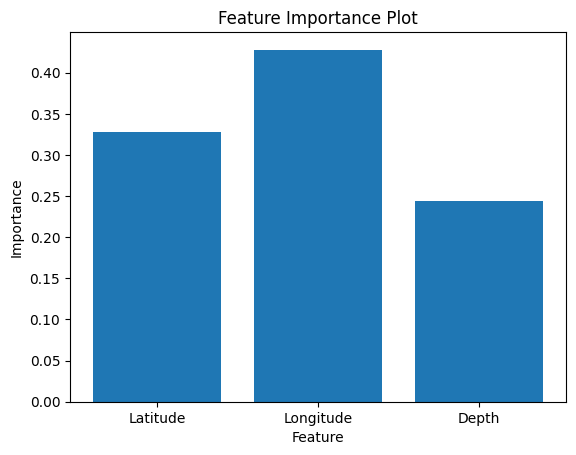

In [ ]:
importances = rf.feature_importances_
features = ['Latitude', 'Longitude', 'Depth']
plt.bar(features, importances)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance Plot')
plt.show()

#Kesimpulan dari model

In [ ]:
scores_df = pd.DataFrame(scores)
display(scores_df)

,Model name,mse,R^2
0,Linear regression,0.643816,0.073797
1,SVM,1.764866,-1.538962
2,Random Forest,0.406132,0.415733


In [ ]:
scores_df[scores_df["mse"] == scores_df["mse"].min()]

,Model name,mse,R^2
2,Random Forest,0.406132,0.415733


In [ ]:
scores_df[scores_df["R^2"] == scores_df["R^2"].max()]

,Model name,mse,R^2
2,Random Forest,0.406132,0.415733
